In [1]:
%load_ext autoreload
%autoreload 2

from primitives.primitives import *
from primitives.tv_model import *
from cirq import Circuit, LineQid, measure, sample, Simulator
import matplotlib.pyplot as plt
from numpy.linalg import eig
import re
from scipy.constants import hbar

simulator = Simulator()

## Evolving a state

In [2]:
def evolve(qudits, temps, initial, T, V):

    if len(temps) > 1:
        evolution_number = evolve_gate(DoubleNumberGate)(C=V, t = temps[1]-temps[0])
        evolution_horizontal_hop = evolve_gate(HopXGate)(C=T, t = (temps[1]-temps[0])/2)
        evolution_vertical_hop = evolve_gate(HopYGate)(C=T, t = (temps[1]-temps[0])/2)
    rows, cols = qudits.shape
    results = []
    evolution_circuit = []
    for idx, t in enumerate(temps):

        if t != 0:    
            # Hopping part
            for row in range(rows):
                for col in range(cols):
                    # horizontal interaction
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_horizontal_hop(a, b))
                    # vertical interaction
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_vertical_hop(a, b))

            # On-site part
            for row in range(rows):
                for col in range(cols):
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_number(a, b))
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_number(a, b))
            # Hopping part
            for row in range(rows):
                for col in range(cols):
                    # horizontal interaction
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_horizontal_hop(a, b))
                    # vertical interaction
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_vertical_hop(a, b))

        circuit = Circuit([*initial, *evolution_circuit])
        results.append((circuit, simulator.simulate(circuit)))
            
    return results

## Evolving a 4x2 lattice

In [3]:
T = -1
V = 0.5

rows = 2
columns = 3
qudits = np.array(LineQid.range(rows * columns, dimension=4)).reshape(rows, columns)


In [4]:
coeffs = (np.random.rand(2)*2-1) + 1j * (np.random.rand(2)*2-1)
coeffs = [1, 1] #0.47430418+0.48681048j, 0.64455866+0.59635361j]

In [5]:
plaquettes = generate_plaquette_constraints(qudits)

# initial circuit that ensures that the correct subspace is used (really?)

projected_subspace = [Project_Constraint()(*pl) for pl in plaquettes]
initial_state = [
    #AddPlaqPair(*coeffs)(qudits[0][0], qudits[0][1], qudits[1][1], qudits[1][0])
    AddTriple(*coeffs)(qudits[0][0], qudits[0][1], qudits[0][2]),
    #AddHorizontalPair()(qudits[0][0], qudits[0][1]),
    #AddVerticalPair()(qudits[0][0], qudits[1][0]),
]
initial_circuit = [*projected_subspace, *initial_state]

In [6]:
final_T = 0.4
num_steps = 1
dt = final_T / num_steps

temps = np.arange(0, final_T+dt/2, dt)


# results is a list of tuples, every tuple contains the circuit and the result shots
results = evolve(qudits, temps, initial_circuit, T=T, V=V)

In [7]:
results[1][0]

┌────────────────┐   ┌────────────────┐                                                               ┌────────────────┐   ┌────────────────┐
0 (d=4): ───P+────────f+(A+B)───H_x(r)──────H_y(r)──────────────────────────────────────────────n(r)───────n(r)───────────────────────H_x(r)──────H_y(r)─────────────────────────────────────────────────────────
            │         │         │           │                                                   │          │                          │           │
1 (d=4): ───P+───P+───f+(A)─────H_x(r+1)────┼───────H_x(r)───────H_y(r)─────────────────────────┼──────────n(r+1)───n(r)─────n(r)─────H_x(r+1)────┼───────H_x(r)───────H_y(r)────────────────────────────────────
            │    │    │                     │       │            │                              │                   │        │                    │       │            │
2 (d=4): ───┼────P+───f+(B)─────────────────┼───────H_x(r+1)─────┼───────H_y(r)─────────────────┼───────────────────┼────────n(r+1)───n(r)────────┼───────H_x(r+1)─────┼───────H_y(r)────────────────────────────
            │    │                          │                    │       │                      │                   │                 │           │                    │       │
3 (d=4): ───P+───┼──────────────────────────H_y(r+1)─────────────┼───────┼───────────H_x(r)─────n(r+1)──────────────┼────────n(r)─────┼───────────H_y(r+1)─────────────┼───────┼───────────H_x(r)────────────────
            │    │                                               │       │           │                              │        │        │                                │       │           │
4 (d=4): ───P+───P+──────────────────────────────────────────────H_y(r+1)┼───────────H_x(r+1)───H_x(r)──────────────n(r+1)───n(r+1)───┼───────────n(r)─────────────────H_y(r+1)┼───────────H_x(r+1)───H_x(r)─────
                 │                                                       │                      │                                     │           │                            │                      │
5 (d=4): ────────P+──────────────────────────────────────────────────────H_y(r+1)───────────────H_x(r+1)──────────────────────────────n(r+1)──────n(r+1)───────────────────────H_y(r+1)───────────────H_x(r+1)───
                                           └────────────────┘   └────────────────┘                                                               └────────────────┘   └────────────────┘

## Operators evolution

In [8]:
line_styles = ['-.', '--', '-.', ':', '-.', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

### Constraints

(-1.1, 1.1)

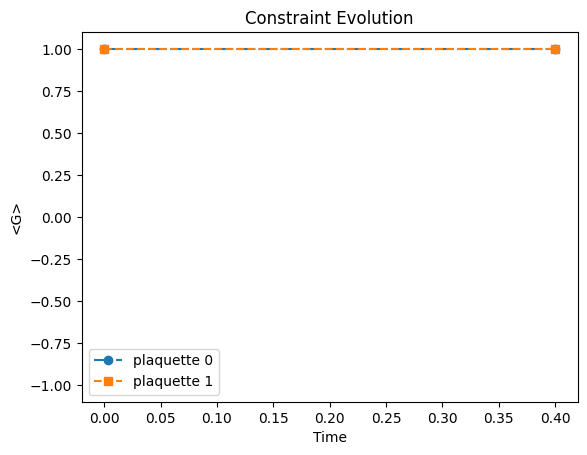

In [9]:
evol_res = {str(idx): [] for idx in range(len(plaquettes))}

for idx, plaquette in enumerate(plaquettes):
    for state in results:
        operator = G
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(np.abs(val))

for idx, i in enumerate(evol_res):
    plt.plot(temps, evol_res[i], label=f"plaquette {idx}", linestyle=line_styles[idx], marker=markers[idx])
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

### Numbers

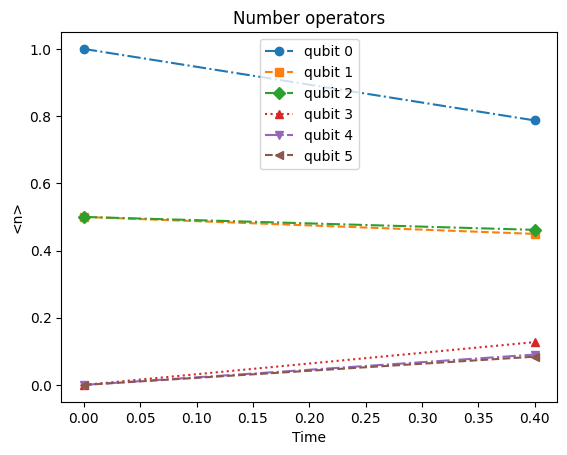

In [10]:
num_evol_res = []

for state in results:
    nums = compute_state_exp_numbers(qudits, state)
    num_evol_res.append(nums)
    
num_evol_res = np.array(num_evol_res)

for i in range(len(qudits.flatten())):
    plt.plot(temps, num_evol_res[:,i], label=f"qubit {i}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

In [11]:
np.sum(num_evol_res, axis=1)

array([2., 2.])

### Hamiltonian

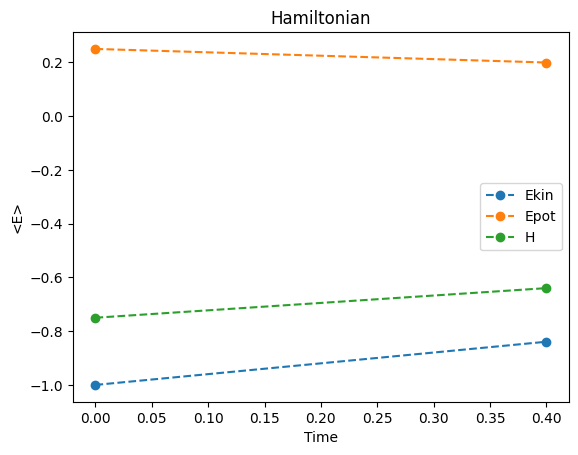

In [12]:
ekin = []
epot = []

for state in results:
    ham_k, ham_p = compute_state_exp_hamiltonian_tv(qudits, state, T, V)
    ekin.append(ham_k)
    epot.append(ham_p)

ekin = np.array(ekin)
epot = np.array(epot)

plt.plot(temps, ekin, "o--", label="Ekin")
plt.plot(temps, epot, "o--", label="Epot")
plt.plot(temps, ekin+epot, "o--", label="H")
    
plt.title("Hamiltonian")
plt.xlabel("Time")
plt.ylabel("<E>")
plt.legend()

In [13]:
# num_steps = 1
N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.4}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0	Pot=0.25	H=-0.75
t = 0.4		Ekin=-0.8393	Pot=0.1994	H=-0.6399


### Check if Trotterization is the problem

In [14]:
T = -1
V = 0.5

In [16]:
final_T = 0.4

nums_steps = [1, 2, 4, 8, 16, 32]


final_results_k = []
final_results_p = []
final_results_h = []
final_results_nums = []

for num_steps in nums_steps:
    print(f"Doing {num_steps} steps")
    
    dt = final_T / num_steps
    temps = np.arange(0, final_T+dt/2, dt)
    # results is a list of tuples, every tuple contains the circuit and the result shots
    results = evolve(qudits, temps, initial_circuit, T=T, V=V)

    ham_k, ham_p = compute_state_exp_hamiltonian_tv(qudits, results[-1], T, V)
    final_results_k.append(ham_k)
    final_results_p.append(ham_p)
    final_results_h.append(ham_k+ham_p)

    nums = compute_state_exp_numbers(qudits, results[-1])
    final_results_nums.append(nums)

Doing 1 steps
Doing 2 steps
Doing 4 steps
Doing 8 steps
Doing 16 steps
Doing 32 steps


Text(0.5, 1.0, 'Tot error on nums')

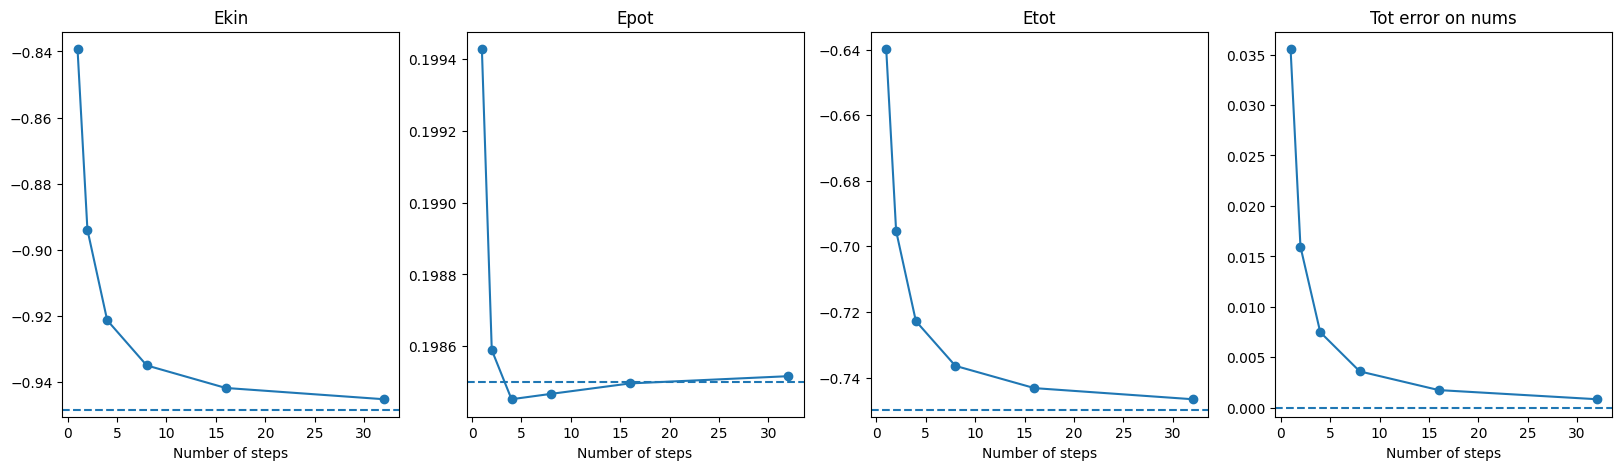

In [17]:
nk_val_k = -0.9485
nk_val_p = 0.1985
nk_val_h = -0.75
nk_numbers = np.array([0.7844, 0.4548, 0.458, 0.1399, 0.0829, 0.08])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

final_results_k = np.array(final_results_k)
final_results_p = np.array(final_results_p)

ax1.plot(nums_steps, final_results_k, "-o", label="Ekin")
ax1.axhline(nk_val_k, linestyle="--", label="NK kin")
ax1.set_xlabel("Number of steps")
ax1.set_title("Ekin")

ax2.plot(nums_steps, final_results_p, "-o", label="Epot")
ax2.axhline(nk_val_p, linestyle="--", label="NK pot")
ax2.set_xlabel("Number of steps")
ax2.set_title("Epot")

ax3.plot(nums_steps, final_results_h, "-o", label="Etot")
ax3.axhline(nk_val_h, linestyle="--", label="NK tot")
ax3.set_xlabel("Number of steps")
ax3.set_title("Etot")

num_error = [np.sum(np.abs(nk_numbers - i)) for i in final_results_nums]
ax4.plot(nums_steps, num_error, "-o", label="Etot")
ax4.axhline(0, linestyle="--", label="NK tot")
ax4.set_xlabel("Number of steps")
ax4.set_title("Tot error on nums")